# Multiple trials

In [959]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%aimport simulation
%aimport mathf
%aimport util
%aimport inference
%aimport graph
%aimport hyper
%aimport seq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [960]:
import os.path
from datetime import datetime
import numpy as np
from scipy import stats
from scipy import linalg
from sklearn.decomposition.factor_analysis import FactorAnalysis
from scipy.io import loadmat, savemat
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat, lagmat2ds
import pandas as pd
from scipy.linalg import orth
from numpy.linalg import norm
from numpy import dstack, rollaxis

import simulation, util, inference, graph, hyper, seq
from mathf import ichol_gauss, subspace
from util import rad2deg, rotate, add_constant

In [587]:
# plot setting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from matplotlib import colors
from matplotlib import gridspec
from matplotlib import cm
from matplotlib.patches import FancyBboxPatch
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import set_matplotlib_formats
import seaborn as sns

In [528]:
sns.set_style("white")
PLDScolor = sns.xkcd_rgb["pale red"]
GPFAcolor =  sns.xkcd_rgb["medium green"]
vLGPcolor = sns.xkcd_rgb["denim blue"]

In [351]:
samplepath = os.path.expanduser("~/data/sample")
outputpath = os.path.expanduser("~/data/output")

## Lorenz latent

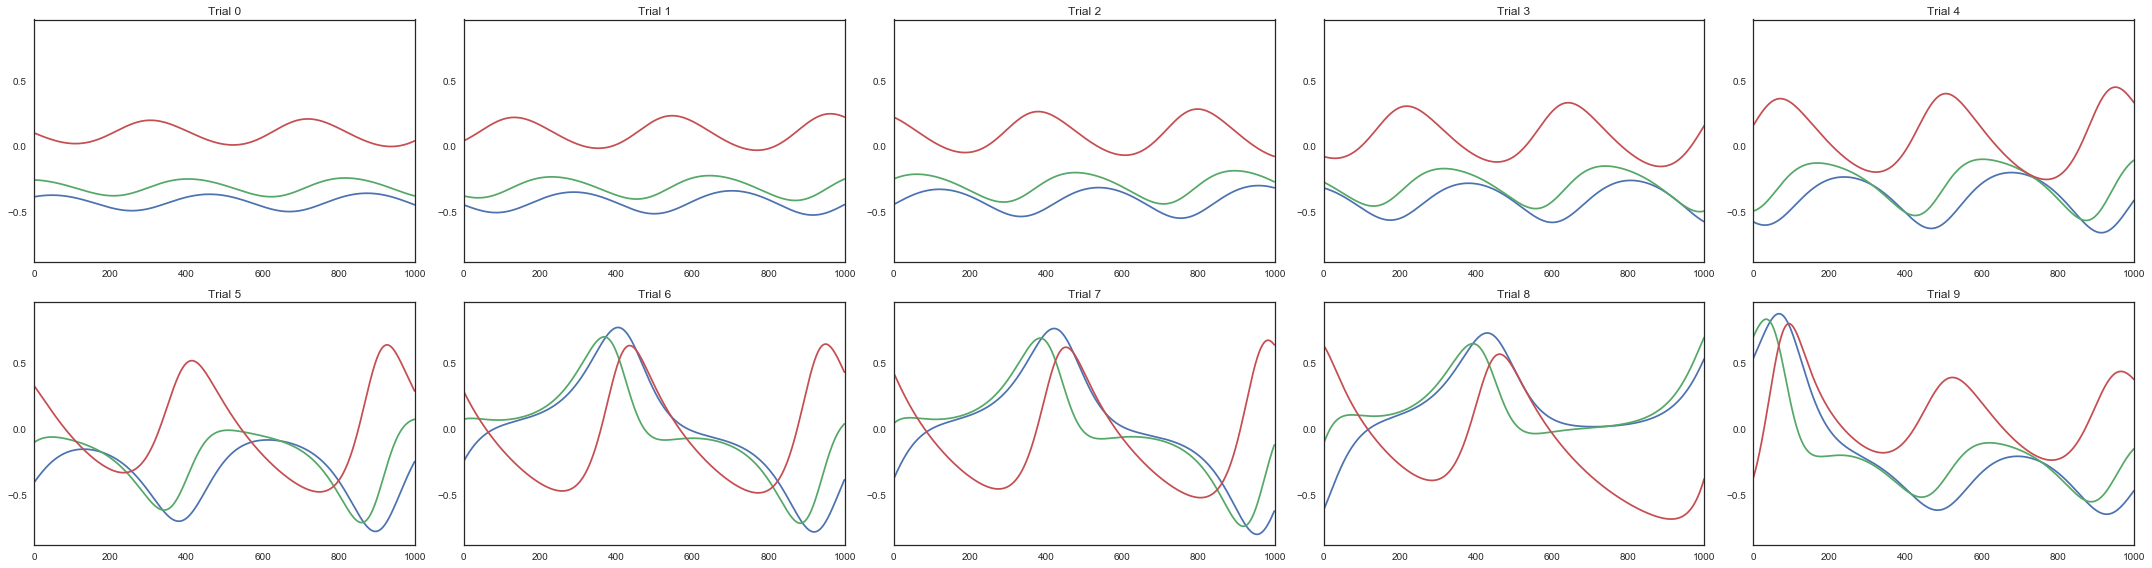

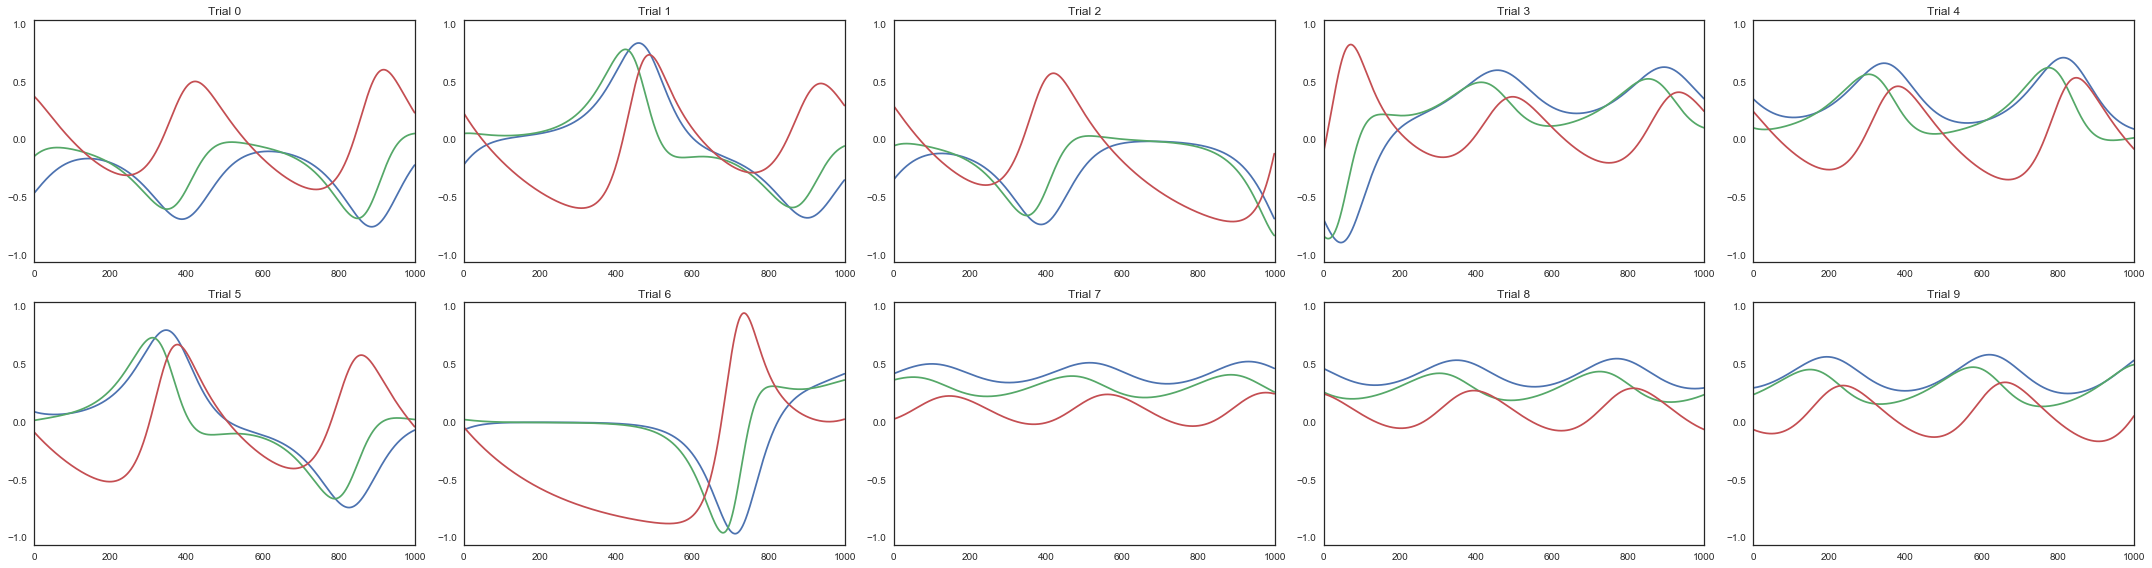

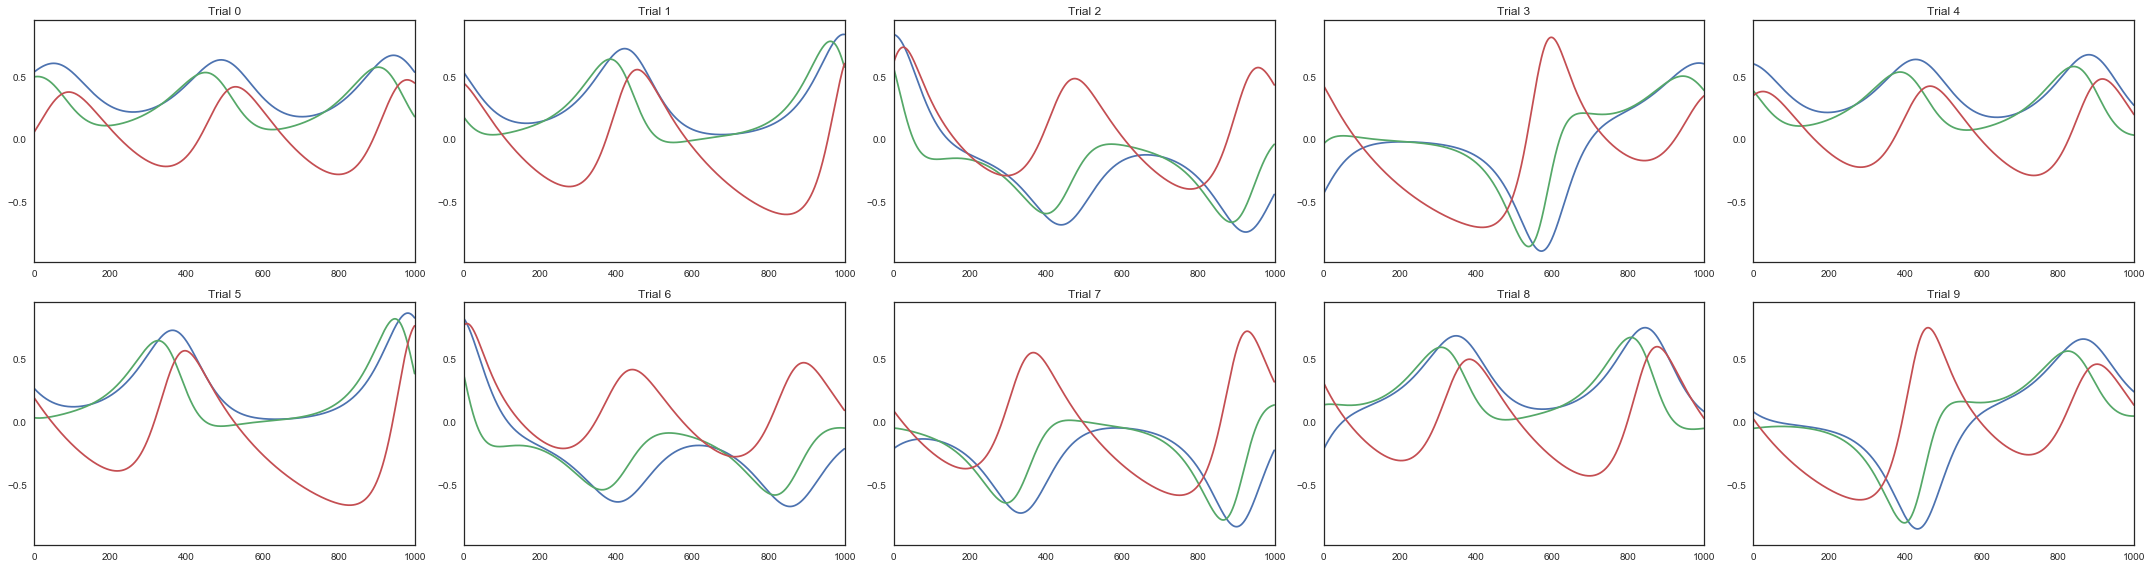

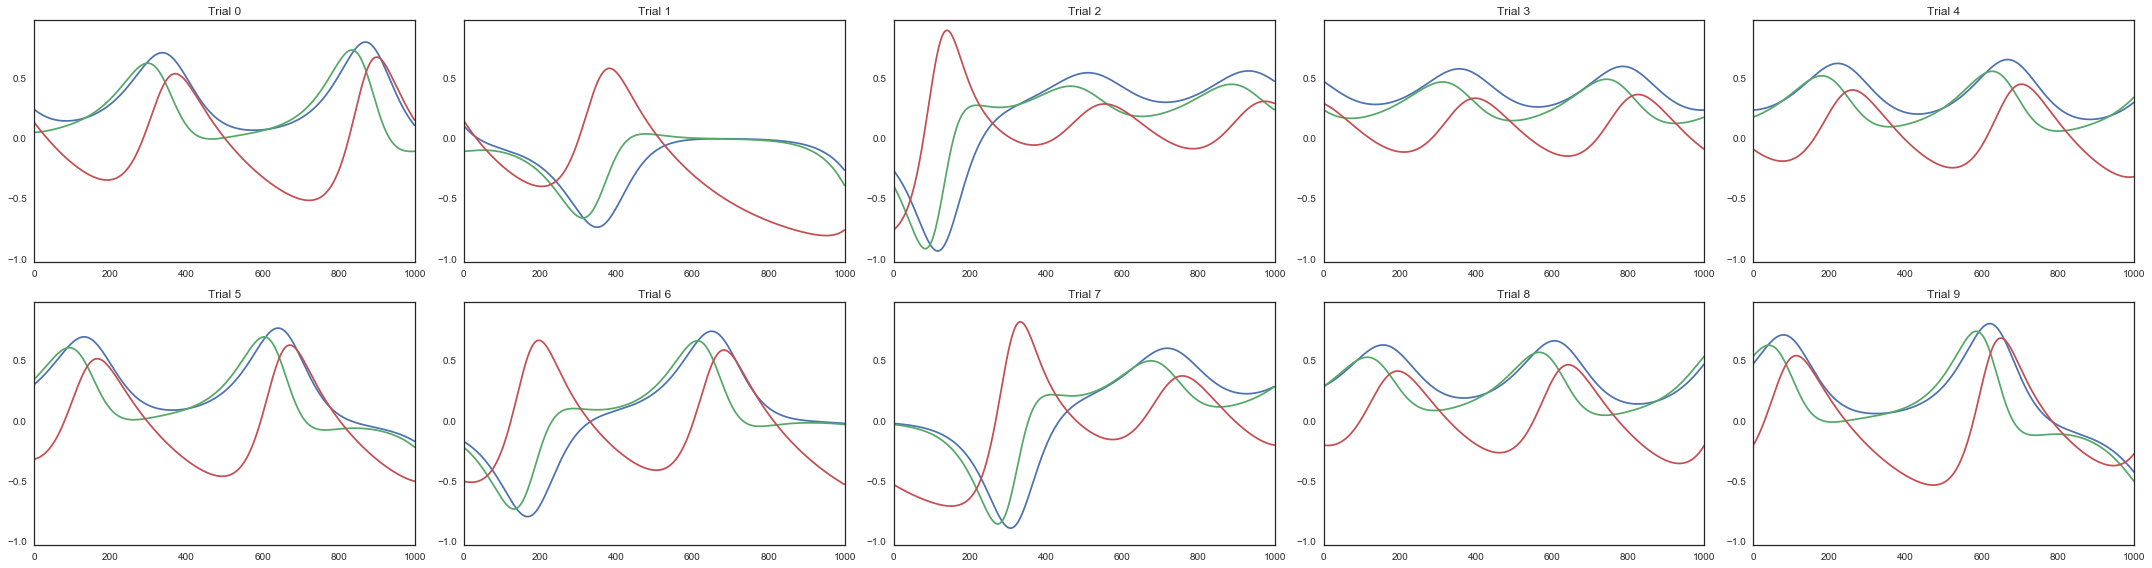

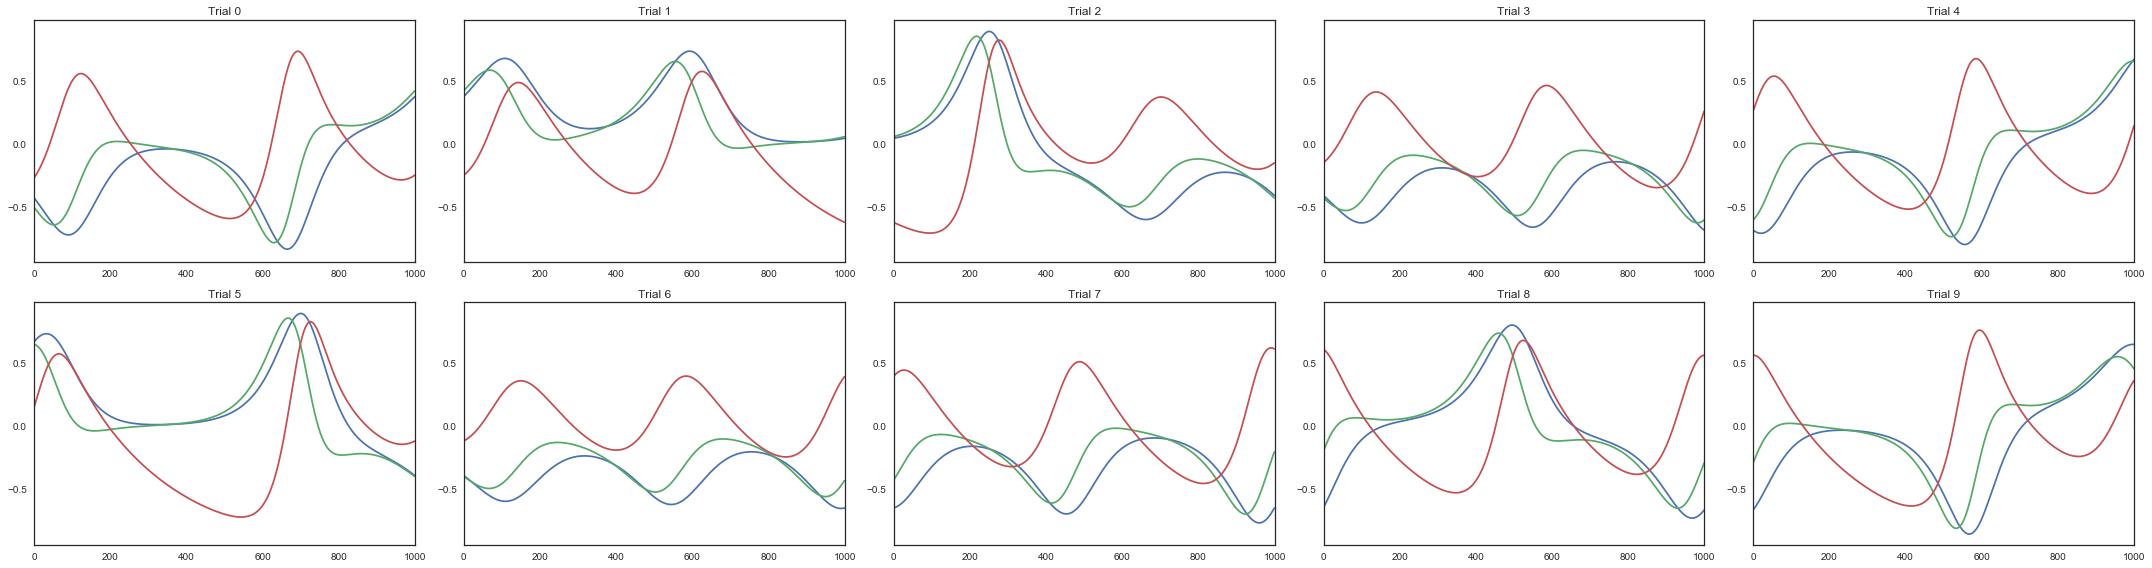

In [707]:
# dimensions
nsample = 5
ntrial = 10
ntime = 1000
nspike = 50
nlatent = 3

np.random.seed(0)
skip = 2000
lorenz = simulation.lorenz(skip + nsample * ntrial * ntime, dt=1.5e-3, x0=np.random.random(3) * 2)
lorenz = (lorenz - lorenz.mean(axis=0)) / norm(lorenz, axis=0, ord=np.inf)
x = lorenz[skip:, :].reshape((nsample, ntrial, ntime, -1))
for i in range(5):
    graph.dynplot(x[i, :], ncol=5)

# Simulate spike trains

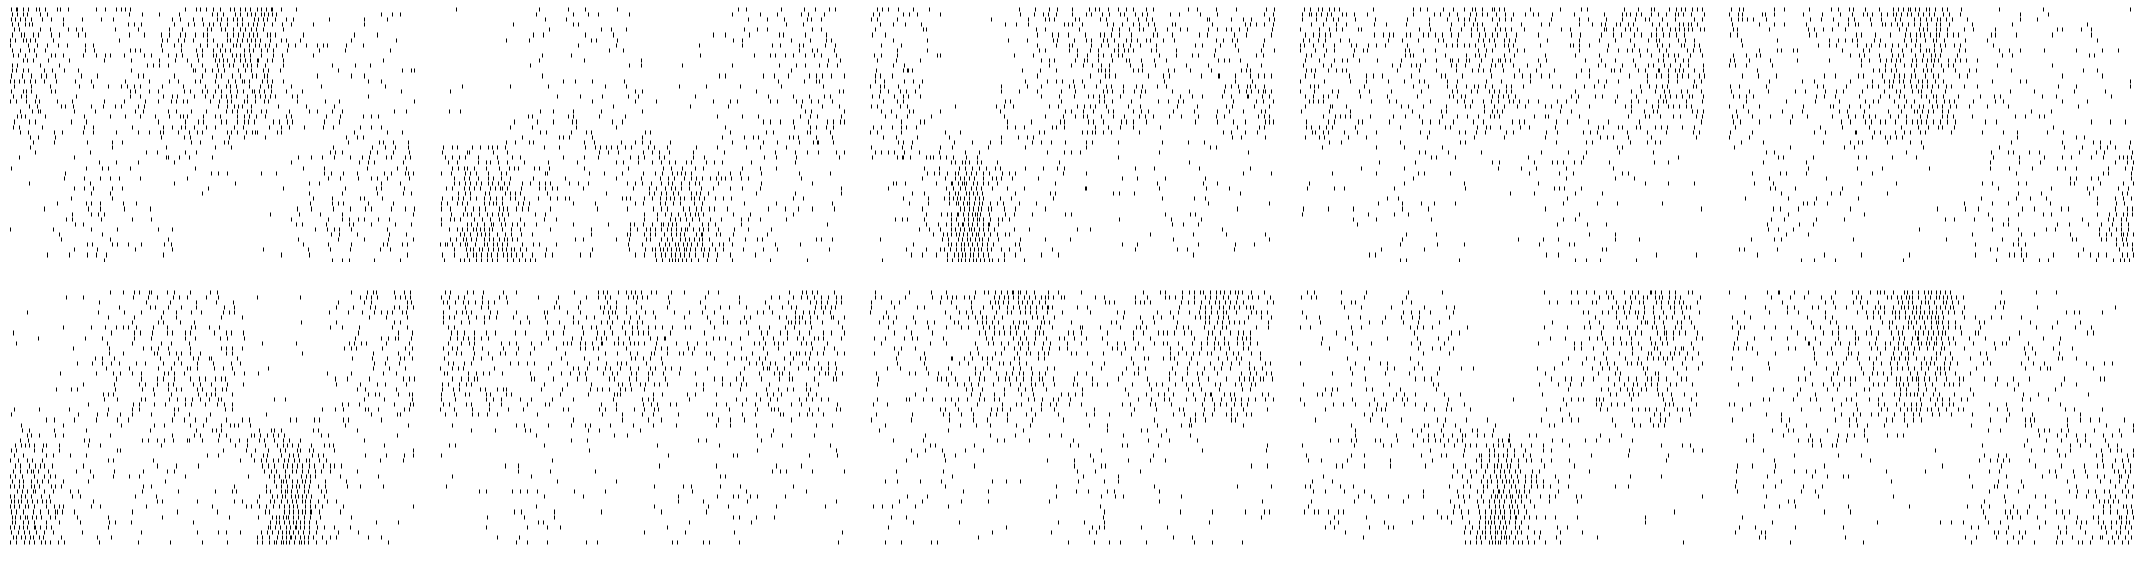

In [761]:
np.random.seed(0)
low = np.log(15 / ntime)
aspk = np.sort((np.random.rand(nlatent, nspike) + 1) * np.sign(np.random.randn(nlatent, nspike)), axis=1)
bspk = np.vstack((low * np.ones(nspike), -10 * np.ones(nspike), -10 * np.ones(nspike), -3 * np.ones(nspike), 
                  -3 * np.ones(nspike), -3 * np.ones(nspike), -3 * np.ones(nspike), -2 * np.ones(nspike),
                  -2 * np.ones(nspike), -1 * np.ones(nspike), -1 * np.ones(nspike)))

y = np.empty((nsample, ntrial, ntime, nspike))  # spike trains
rate = np.empty_like(y)  # firing rates
LorenzSample = []
fsample = []

for i in range(nsample):
    y[i, :], _, rate[i, :] = simulation.spike(x[i, :], aspk, bspk)
#     print('mean firing rate per neuron', y.mean(axis=(0, 1)) * 1000)
    LorenzSample.append({'y': y[i, :], 'rate': rate[i, :], 'x': x[i, :], 'alpha': aspk, 'beta':bspk})
    fname = '{}/lorenz_{}'.format(samplepath, i + 1)
    fsample.append(fname)
    savemat(fname, LorenzSample[i])
graph.rasterplot(y[nsample - 1, :], ncol=5);

In [1284]:
for i in range(nsample):
    print('Sample {}'.format(i + 1))
    print('\t Mean spike per neuron\n\t', LorenzSample[i]['y'].mean(axis=(0, 1)) * ntime)
    print('\t Mean spike\n\t', LorenzSample[i]['y'].mean() * ntime)

Sample 1
	 Mean spike per neuron
	 [ 29.2  30.5  27.9  26.9  27.   28.1  27.7  26.3  26.4  25.9  25.3  26.7
  25.4  23.7  23.6  22.8  22.9  23.6  22.   22.5  22.5  19.1  20.3  19.4
  21.2  12.3  12.    9.6  11.3   9.8  10.3  11.2  11.6  10.6  10.3  12.
  10.5  10.1  10.8  11.1  11.5  10.9  10.7  12.4  11.   10.6  11.3  11.1
  11.    9.7]
	 Mean spike
	 17.812
Sample 2
	 Mean spike per neuron
	 [ 16.5  17.6  18.   15.4  17.1  15.9  17.9  15.3  16.2  15.8  16.9  14.8
  16.4  15.8  15.4  15.8  13.9  16.2  15.6  16.9  15.   13.2  15.3  14.7
  13.1  13.8  12.9  20.3  19.2  21.2  19.   19.3  20.4  18.4  22.3  23.1
  21.7  23.7  22.2  23.4  24.2  24.1  24.6  25.1  25.1  25.4  26.8  27.2
  28.2  27. ]
	 Mean spike
	 19.066
Sample 3
	 Mean spike per neuron
	 [ 18.5  19.3  18.8  17.7  16.9  16.2  18.3  16.5  15.5  17.8  18.1  14.8
  15.8  16.7  14.3  16.3  16.5  15.4  15.4  16.   15.6  16.8  14.6  14.7
  15.7  13.8  14.7  17.5  20.5  20.   18.1  18.3  17.5  21.3  20.7  21.9
  22.7  21.1  22.4  2

In [1006]:
fLorenzSample = ['{}/lorenz_{}'.format(samplepath, i + 1) for i in range(nsample)]

for i, fname in enumerate(fLorenzSample):
    print('Sample {}'.format(i + 1))
    sigma = np.full(nlatent, fill_value=1.0)
    omega = np.full(nlatent, fill_value=1e-5)
    sample = loadmat(fname, squeeze_me=True)
    result = inference.fit(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, x=sample['x'], 
                                   alpha=sample['alpha'], beta=sample['beta'], lag=10, rank=100, 
                                   niter=100, tol=1e-5, verbose=False, hyper=True)
    savemat('{}/lorenz_{}_vLGP'.format(outputpath, i + 1), result)
print('Done.')

# Collect results
Lorenz_vLGP = []
for i, fname in enumerate(fLorenzSample):
    Lorenz_vLGP.append(loadmat('{}/lorenz_{}_vLGP'.format(outputpath, i + 1), squeeze_me=True))

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Done.


In [1009]:
# cv
fLorenzSample = ['{}/lorenz_{}'.format(samplepath, i + 1) for i in range(nsample)]
LorenzCV_vLGP = []

for i, fname in enumerate(fLorenzSample):
    print('Sample {}'.format(i + 1))
    sigma = np.full(nlatent, fill_value=1.0)
    omega = Lorenz_vLGP[i]['omega']
    sample = loadmat(fname, squeeze_me=True)
    result = inference.cv(sample['y'], ['spike'] * sample['y'].shape[-1], sigma, omega, lag=10, rank=100, 
                                   niter=100, tol=1e-5, hyper=False)
    savemat('{}/lorenz_{}_vLGP_pred'.format(outputpath, i + 1), result)
    LorenzCV_vLGP.append(result)
print('Done.')

Sample 1
Sample 2
Sample 3
Sample 4
Sample 5
Done.


Sample 3
Latent subspace angle: 40.02 deg
Loading subspace angle: 84.24 deg


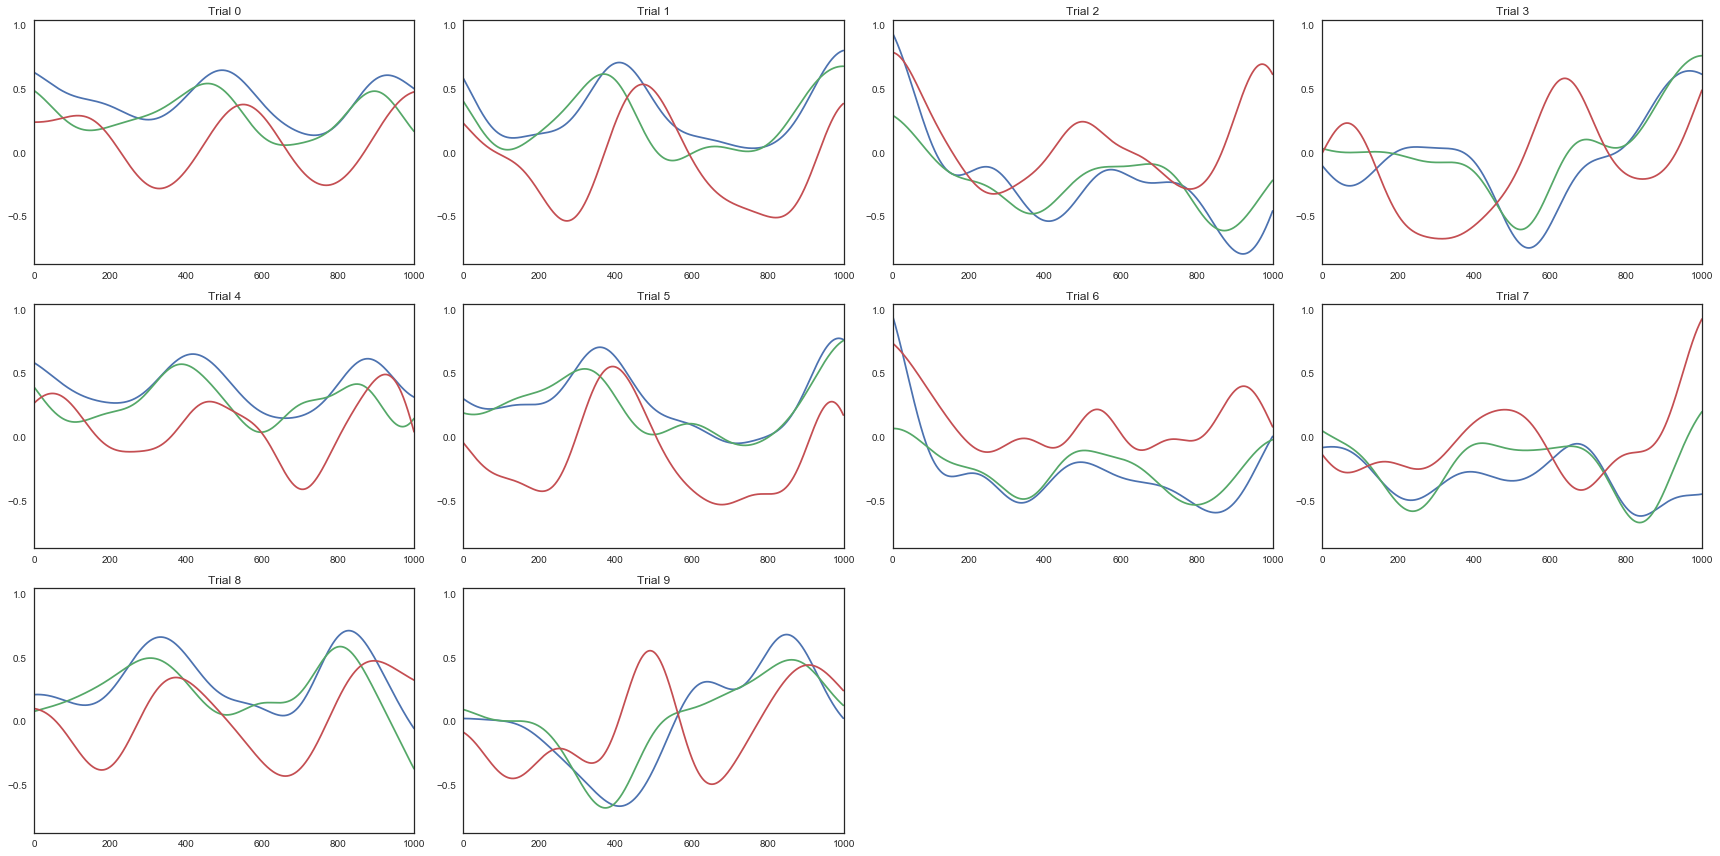

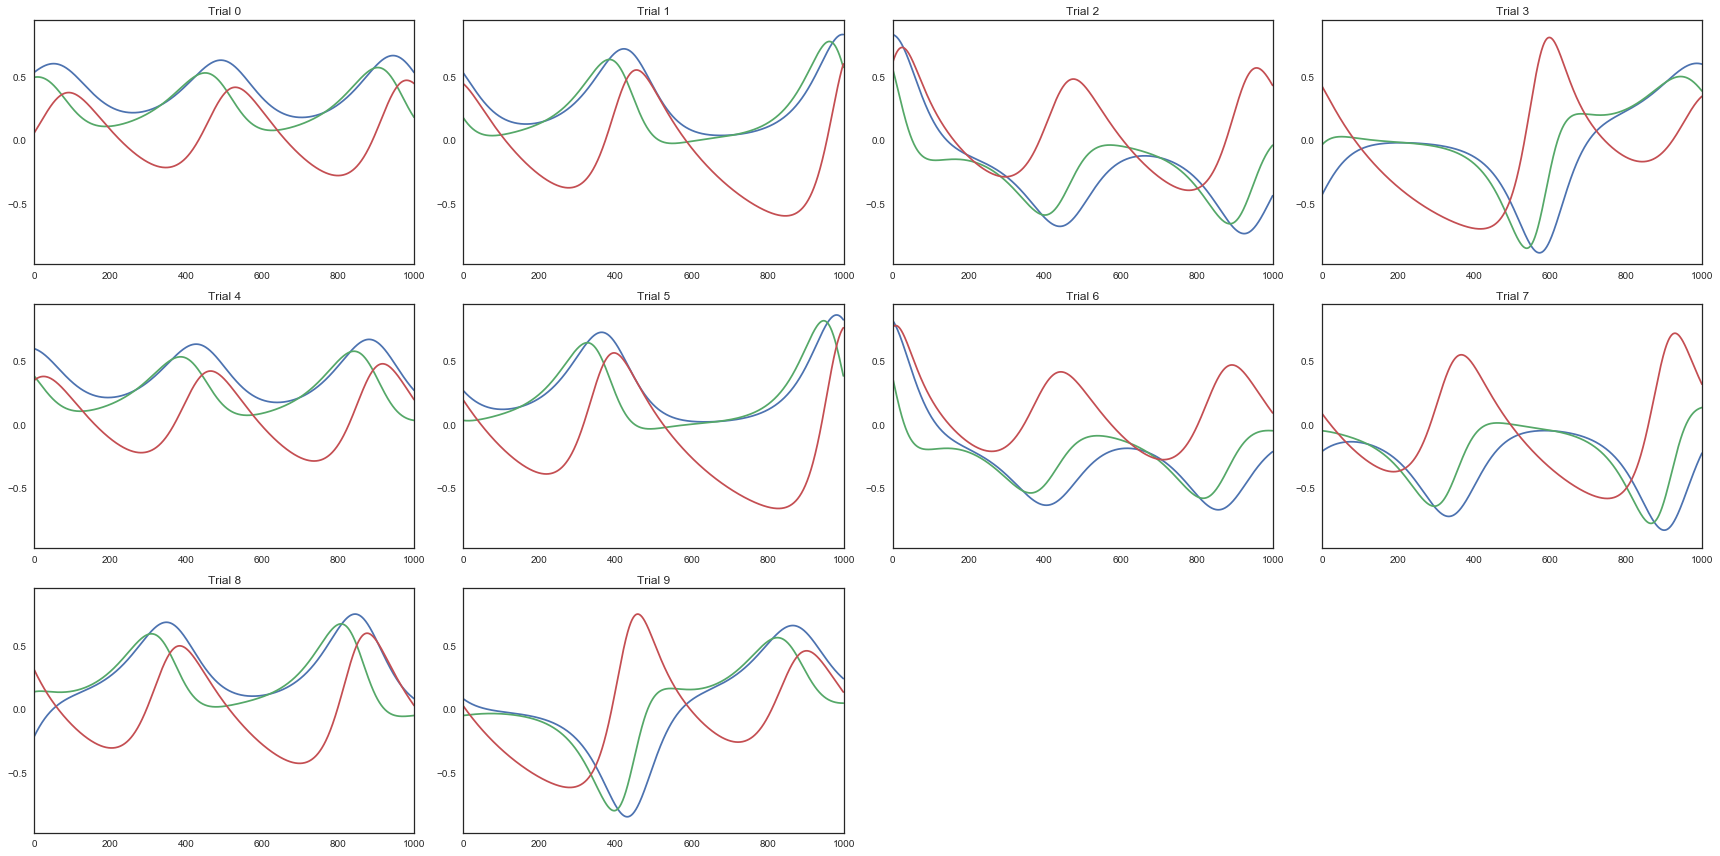

In [1007]:
idx = np.array([r['LatentAngle'][-1] for r in Lorenz_vLGP]).argmin()
# idx = 2
print('Sample {}'.format(idx + 1))
bestvLGP = Lorenz_vLGP[idx]
print('Latent subspace angle: {:.2f} deg'.format(rad2deg(bestvLGP['LatentAngle'][-1])))
print('Loading subspace angle: {:.2f} deg'.format(rad2deg(bestvLGP['LoadingAngle'][-1])))
# bestvLGPx = util.align(bestvLGP['mu'])
bestvLGPx = bestvLGP['mu']
rotated = np.empty_like(bestvLGPx)
for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestvLGPx[i, :]), bestvLGP['x'][i, :])

# rotated = util.align(rotated)
graph.dynplot(rotated.reshape((ntrial, -1, nlatent)))
graph.dynplot(bestvLGP['x'])
# plt.savefig(os.path.join(outputpath, 'best_proposed_rotation_lorenz_sample.pdf'))


# fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='3d'))
# # recon = rotated.reshape((-1, nlatent))
# for m in range(ntrial):
#     ax[0].plot(rotated[m, :, 0], rotated[m, :, 1], rotated[m, :, 2], lw=1, color=vLGPcolor);
# # ax[0].plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
# ax[0].set_xlim3d(-1, 1);
# ax[0].set_ylim3d(-1, 1);
# ax[0].set_zlim3d(-1, 1);
# ax[0].set_title('Proposed reconstruction of Sample {}'.format(idx + 1));
# ax[1].plot(bestvLGP['x'].reshape((-1, nlatent))[:, 0], bestvLGP['x'].reshape((-1, nlatent))[:, 1], bestvLGP['x'].reshape((-1, nlatent))[:, 2], lw=1);
# ax[1].set_xlim3d(-1, 1);
# ax[1].set_ylim3d(-1, 1);
# ax[1].set_zlim3d(-1, 1);
# ax[1].set_title('True latent of Sample {}'.format(idx + 1));

In [534]:
# Run GPFA before loading GPFA results
Lorenz_GPFA = []
for i, fname in enumerate(fLorenzSample):
    Lorenz_GPFA.append(loadmat('{}/lorenz_{}_GPFA'.format(outputpath, i + 1), squeeze_me=True))

Sample 1
Latent subspace angle: 60.03 deg
Loading subspace angle: 80.50 deg
50.3027709059


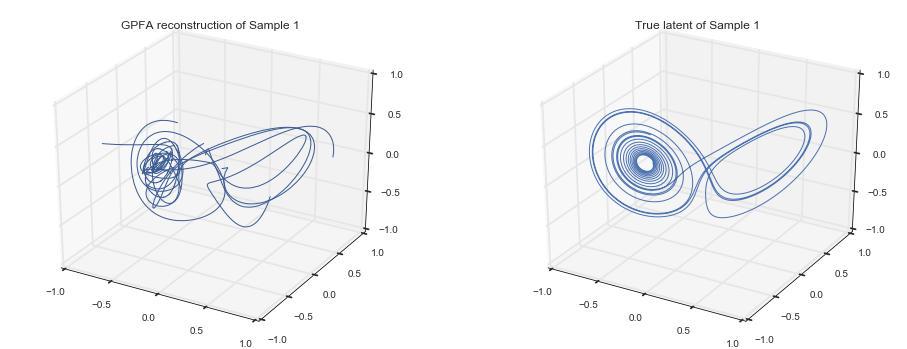

In [596]:
idx = np.array([r['latentAngle'][-1] for r in Lorenz_GPFA]).argmin()
print('Sample {}'.format(idx + 1))
bestGPFA = Lorenz_GPFA[idx]
print('Latent subspace angle: {:.2f} deg'.format(rad2deg(bestGPFA['latentAngle'][-1])))
print('Loading subspace angle: {:.2f} deg'.format(rad2deg(bestGPFA['loadingAngle'][-1])))
bestmu = np.rollaxis(np.dstack(bestGPFA['seqTrain']['xsm']), axis=-1).transpose((0, 2, 1))
bestx = np.rollaxis(np.dstack(bestGPFA['seqTrain']['x']), axis=-1).transpose((0, 2, 1))
rotated = np.empty_like(bestmu)

for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestmu[i, :]), bestx[i, :])

# rotated = util.align(rotated)
print(rad2deg(subspace(rotated.reshape((-1, nlatent)), bestx.reshape((-1, nlatent)))))
# graph.dynplot(rotated.reshape((ntrial, -1, nlatent)))
# graph.dynplot(bestx)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='3d'))
# recon = rotated.reshape((-1, nlatent))
for m in range(ntrial):
    ax[0].plot(rotated[m, :, 0], rotated[m, :, 1], rotated[m, :, 2], lw=1, color=vLGPcolor);
ax[0].set_xlim3d(-1, 1);
ax[0].set_ylim3d(-1, 1);
ax[0].set_zlim3d(-1, 1);
ax[0].set_title('GPFA reconstruction of Sample {}'.format(idx + 1));
ax[1].plot(bestx.reshape((-1, nlatent))[:, 0], bestx.reshape((-1, nlatent))[:, 1], bestx.reshape((-1, nlatent))[:, 2], lw=1);
ax[1].set_xlim3d(-1, 1);
ax[1].set_ylim3d(-1, 1);
ax[1].set_zlim3d(-1, 1);
ax[1].set_title('True latent of Sample {}'.format(idx + 1));

In [906]:
# Run GPFA before loading GPFA results
Lorenz_PLDS = []
for i, fname in enumerate(fLorenzSample):
    Lorenz_PLDS.append(loadmat('{}/lorenz_{}_PLDS'.format(outputpath, i + 1), squeeze_me=True))

Sample 1
Latent subspace angle: 62.00 deg
Loading subspace angle: 71.35 deg
62.004120559


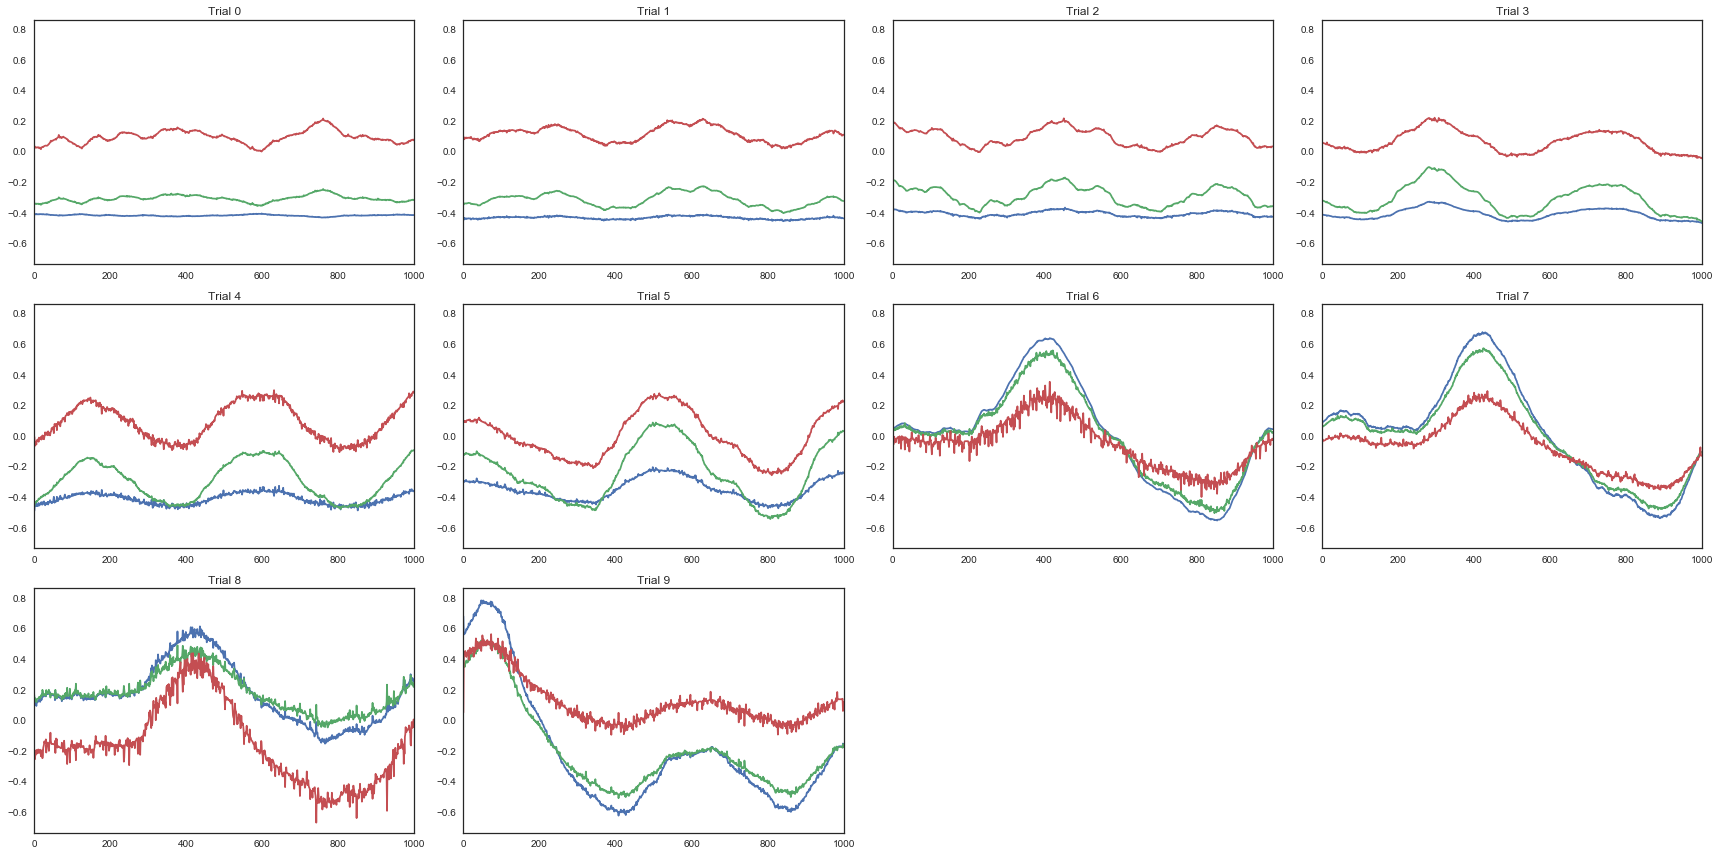

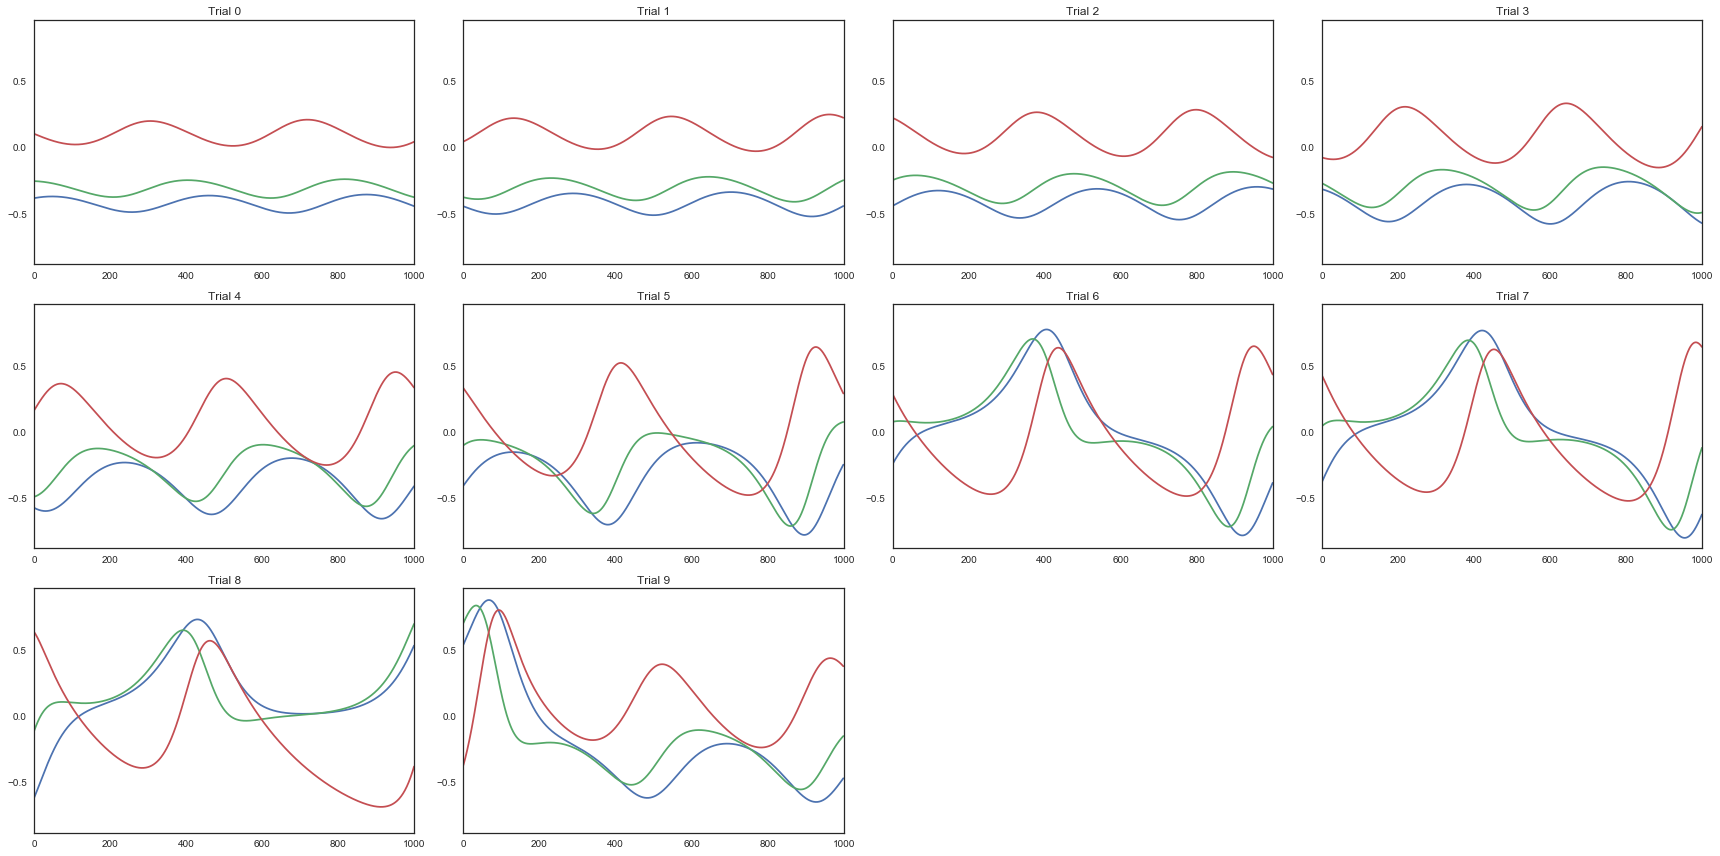

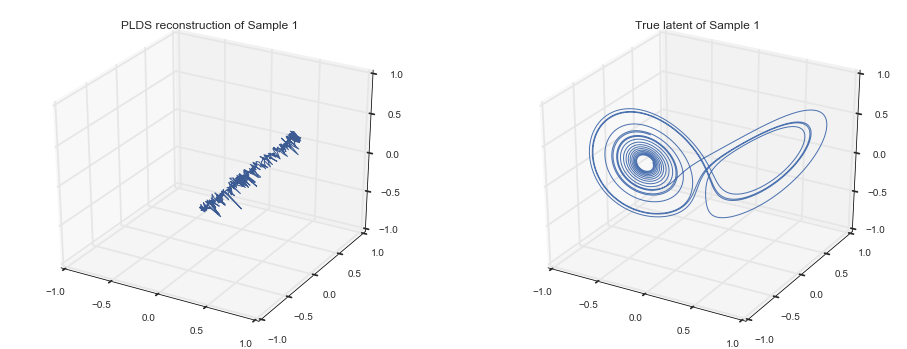

In [909]:
idx = np.nanargmin(np.array([r['latentAngle'][-1] for r in Lorenz_PLDS]))
print('Sample {}'.format(idx + 1))
bestPLDS = Lorenz_PLDS[idx]
print('Latent subspace angle: {:.2f} deg'.format(rad2deg(bestPLDS['latentAngle'][-1])))
print('Loading subspace angle: {:.2f} deg'.format(rad2deg(bestPLDS['loadingAngle'][-1])))

bestmu = np.rollaxis(bestPLDS['xsm'], axis=-1).transpose((0, 2, 1))
bestx = np.rollaxis(np.dstack(bestPLDS['seq']['x']), axis=-1).transpose((0, 2, 1))
rotated = np.empty_like(bestmu)

for i in range(ntrial):
    rotated[i, :] = util.rotate(util.add_constant(bestmu[i, :]), bestx[i, :])

# rotated = util.align(rotated)
print(rad2deg(subspace(rotated.reshape((-1, nlatent)), bestx.reshape((-1, nlatent)))))
graph.dynplot(rotated.reshape((ntrial, -1, nlatent)))
graph.dynplot(bestx)

fig, ax = plt.subplots(1, 2, figsize=(16, 6), subplot_kw=dict(projection='3d'))
recon = rotated.reshape((-1, nlatent))
# for m in range(ntrial):
ax[0].plot(rotated[8, :, 0], rotated[8, :, 1], rotated[8, :, 2], lw=1, color=vLGPcolor);

# ax[0].plot(recon[:, 0], recon[:, 1], recon[:, 2], lw=1);
ax[0].set_xlim3d(-1, 1);
ax[0].set_ylim3d(-1, 1);
ax[0].set_zlim3d(-1, 1);

ax[0].set_title('PLDS reconstruction of Sample {}'.format(idx + 1));
ax[1].plot(bestx.reshape((-1, nlatent))[:, 0], bestx.reshape((-1, nlatent))[:, 1], bestx.reshape((-1, nlatent))[:, 2], lw=1);
ax[1].set_xlim3d(-1, 1);
ax[1].set_ylim3d(-1, 1);
ax[1].set_zlim3d(-1, 1);
ax[1].set_title('True latent of Sample {}'.format(idx + 1));

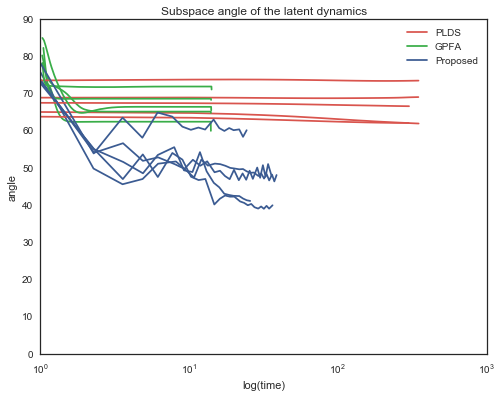

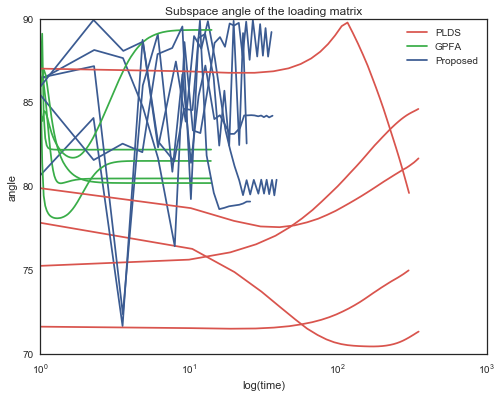

In [1285]:
plt.figure(figsize=(8, 6));
for i in range(nsample):
    Lorenz_PLDS[i]['Time'][0] = 1
    Lorenz_GPFA[i]['iterTime'][0] = 1
    Lorenz_vLGP[i]['Elapsed'][0, :] = 1
    plt.semilogx(np.cumsum(Lorenz_PLDS[i]['Time']), rad2deg(Lorenz_PLDS[i]['latentAngle'][1:]), color=PLDScolor);
    plt.semilogx(np.cumsum(Lorenz_GPFA[i]['iterTime']), rad2deg(Lorenz_GPFA[i]['latentAngle']), color=GPFAcolor);
    plt.semilogx(np.cumsum(Lorenz_vLGP[i]['Elapsed'][:,2]), rad2deg(Lorenz_vLGP[i]['LatentAngle']), color=vLGPcolor);
plt.xlabel('log(time)');
plt.ylabel('angle');
plt.title('Subspace angle of the latent dynamics');
plt.ylim([0, 90]);
PLDSline = Line2D((0, 0), (1, 1), color=PLDScolor);
GPFAline = Line2D((0, 0), (1, 1), color=GPFAcolor);
vLGPline = Line2D((0, 0), (1, 1), color=vLGPcolor);
plt.legend(handles=[PLDSline, GPFAline, vLGPline], labels=['PLDS', 'GPFA', 'Proposed']);
plt.savefig(os.path.join(outputpath, 'latent_angle_of_lorenz_sample.pdf'))

plt.figure(figsize=(8, 6));
for i in range(nsample):
    Lorenz_PLDS[i]['Time'][0] = 1
    Lorenz_GPFA[i]['iterTime'][0] = 1
    Lorenz_vLGP[i]['Elapsed'][0, :] = 1
    plt.semilogx(np.cumsum(Lorenz_PLDS[i]['Time']), rad2deg(Lorenz_PLDS[i]['loadingAngle']), color=PLDScolor);
    plt.semilogx(np.cumsum(Lorenz_GPFA[i]['iterTime']), rad2deg(Lorenz_GPFA[i]['loadingAngle']), color=GPFAcolor);
    plt.semilogx(np.cumsum(Lorenz_vLGP[i]['Elapsed'][:,2]), rad2deg(Lorenz_vLGP[i]['LoadingAngle']), color=vLGPcolor);
plt.xlabel('log(time)');
plt.ylabel('angle');
plt.title('Subspace angle of the loading matrix');
plt.legend(handles=[PLDSline, GPFAline, vLGPline], labels=['PLDS', 'GPFA', 'Proposed']);

In [1010]:
LorenzCV_vLGP = [loadmat('{}/lorenz_{}_vLGP_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]
LorenzCV_PLDS = [loadmat('{}/lorenz_{}_PLDS_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]
LorenzCV_GPFA = [loadmat('{}/lorenz_{}_GPFA_pred'.format(outputpath, i + 1), squeeze_me=True) for i in range(nsample)]

## firing rate MSE

In [1018]:
mse = 0.0
for i in range(5):
    mse += np.mean((rate[i, :].ravel() - LorenzCV_vLGP[i]['yhat'].ravel()) ** 2)
print(mse)

0.00205215164034


In [1019]:
mse = 0.0
for i in range(5):
    mse += np.mean((rate[i, :].ravel() - LorenzCV_PLDS[i]['yhat'].ravel()) ** 2)
print(mse)

0.00257784735211


In [1020]:
mse = 0.0
for i in range(5):
    mse += np.mean((rate[i, :].ravel() - LorenzCV_GPFA[i]['yhat'].ravel()) ** 2)
print(mse)

0.00525039059987


In [1021]:
mse = 0.0
for i in range(5):
    mse += np.mean((rate[i, :].ravel() - LorenzCV_GPFA[i]['yhat'].ravel() ** 2) ** 2)
print(mse)

0.00576129368134


## dif

Ttest_1sampResult(statistic=18.159655877600454, pvalue=1.1375058535183019e-73)
Ttest_1sampResult(statistic=-3.8111272887408396, pvalue=0.00013835106640344659)
Ttest_1sampResult(statistic=-17.035566976066214, pvalue=4.667544793431962e-65)
Ttest_1sampResult(statistic=1.7703237110654328, pvalue=0.076673839562200974)
Ttest_1sampResult(statistic=15.883764049353367, pvalue=8.4775664155034842e-57)


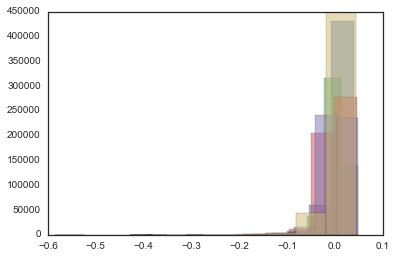

In [1073]:
for i in range(5):
    diff = mu[i, :] - LorenzCV_vLGP[i]['yhat']
    plt.hist(diff.ravel(), alpha=0.5);
    print(stats.ttest_1samp(diff.ravel(), 0))

Ttest_1sampResult(statistic=1256.3945162959353, pvalue=0.0)
Ttest_1sampResult(statistic=1061.0099257003769, pvalue=0.0)
Ttest_1sampResult(statistic=1218.9886782071205, pvalue=0.0)
Ttest_1sampResult(statistic=1236.2260167629099, pvalue=0.0)
Ttest_1sampResult(statistic=1441.9273689339009, pvalue=0.0)


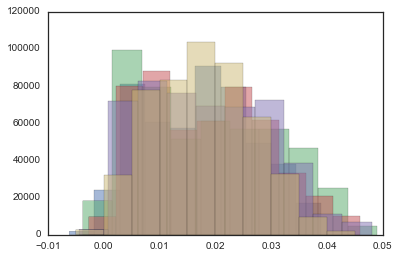

In [1072]:
for i in range(5):
    diff = mu[i, :] - LorenzCV_GPFA[i]['yhat']
    plt.hist(diff.ravel(), alpha=0.5);
    print(stats.ttest_1samp(diff.ravel(), 0))

Ttest_1sampResult(statistic=60.585674812269303, pvalue=0.0)
Ttest_1sampResult(statistic=46.402888037479812, pvalue=0.0)
Ttest_1sampResult(statistic=44.331853854954602, pvalue=0.0)
Ttest_1sampResult(statistic=40.345978144822077, pvalue=0.0)
Ttest_1sampResult(statistic=43.790400916656566, pvalue=0.0)


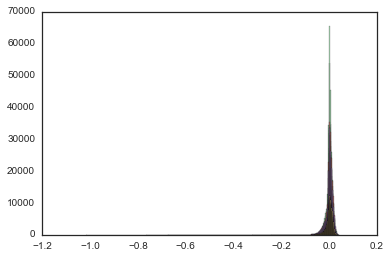

In [1090]:
for i in range(5):
    diff = mu[i, :] - LorenzCV_PLDS[i]['yhat']
    plt.hist(diff.ravel(), alpha=0.5, bins=500);
    print(stats.ttest_1samp(diff.ravel(), 0))

Ttest_1sampResult(statistic=-50.319450466248753, pvalue=0.0)
Ttest_1sampResult(statistic=-2.631781330901517, pvalue=0.0084941119204268098)
Ttest_1sampResult(statistic=-1.6217017332222932, pvalue=0.10486785804959606)
Ttest_1sampResult(statistic=3.4904761780744855, pvalue=0.000482202114747796)
Ttest_1sampResult(statistic=-21.69636407838582, pvalue=2.4815627200511998e-104)


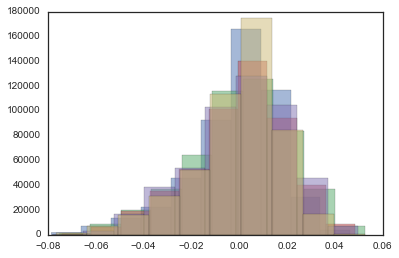

In [1075]:
for i in range(5):
    diff = mu[i, :] - LorenzCV_GPFA[i]['yhat']
    plt.hist(diff.ravel(), alpha=0.5);
    print(stats.ttest_1samp(diff.ravel(), 0))

Ttest_1sampResult(statistic=-58.680457104522688, pvalue=0.0)
Ttest_1sampResult(statistic=-9.5978920281673261, pvalue=8.1950484944601162e-22)
Ttest_1sampResult(statistic=-8.9004956491336937, pvalue=5.5776949507717062e-19)
Ttest_1sampResult(statistic=-3.6448776828047422, pvalue=0.00026754608646852512)
Ttest_1sampResult(statistic=-29.765853213604544, pvalue=1.6018293734374606e-194)


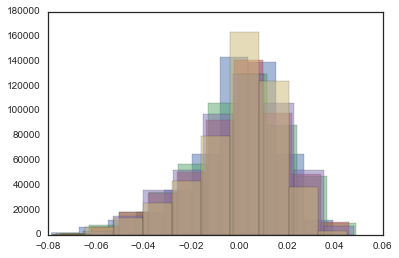

In [1078]:
for i in range(5):
    diff = mu[i, :] - np.abs(LorenzCV_GPFA[i]['yhat'])
    plt.hist(diff.ravel(), alpha=0.5);
    print(stats.ttest_1samp(diff.ravel(), 0))

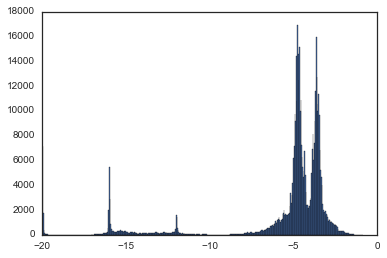

In [1089]:
plt.hist(np.log(LorenzCV_vLGP[0]['yhat'].ravel()), bins=500);

/Users/yuan/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


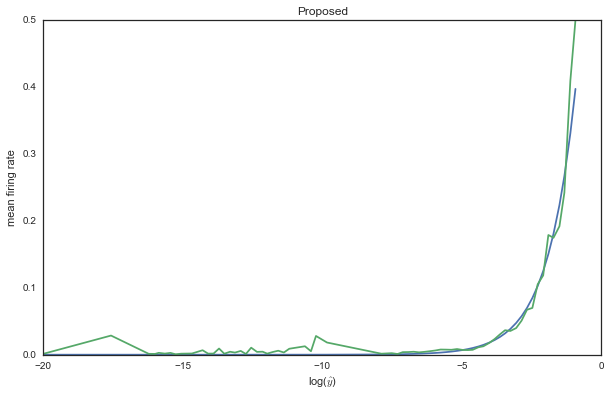

In [1231]:
nbin = 100
logmu = np.log(LorenzCV_vLGP[0]['yhat']).ravel()
bins = np.linspace(start=logmu.min(), stop=logmu.max(), num=nbin)
inds = np.digitize(logmu, bins)
cnt = np.zeros(nbin, dtype=float)
fr = np.zeros(nbin, dtype=float)
pr = np.zeros(nbin, dtype=float)
for i in range(nbin):
    cnt[i] = ((LorenzCV_vLGP[0]['y'].ravel())[inds == i + 1]).sum()
    fr[i] = ((LorenzCV_vLGP[0]['y'].ravel())[inds == i + 1]).mean()
    pr[i] = (np.log(LorenzCV_vLGP[0]['yhat'].ravel())[inds == i + 1]).mean()
plt.figure(figsize=(10, 6))

plt.plot(pr[fr > 0], np.exp(pr[fr > 0]));
plt.plot(pr[fr > 0], fr[fr > 0]);
plt.title('Proposed');
plt.xlabel(r'log($\hat{y}$)');
plt.ylabel(r'mean firing rate');

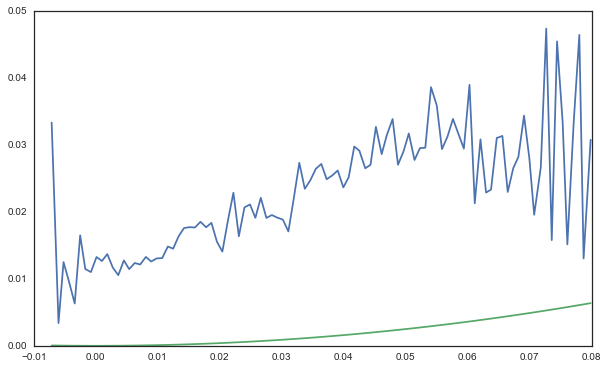

In [1236]:
logmu = LorenzCV_GPFA[0]['yhat'].ravel()
bins = np.linspace(start=logmu.min(), stop=logmu.max(), num=nbin)
inds = np.digitize(logmu, bins)
fr = np.zeros(nbin, dtype=float)
pr = np.zeros(nbin, dtype=float)
for i in range(nbin):
    fr[i] = ((LorenzCV_vLGP[0]['y'].ravel())[inds == i + 1]).mean()
    pr[i] = (LorenzCV_GPFA[0]['yhat'].ravel()[inds == i + 1]).mean()
plt.figure(figsize=(10, 6))
plt.plot(pr[fr > 0], fr[fr > 0]);
plt.plot(pr[fr > 0], pr[fr > 0]**2);

/Users/yuan/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


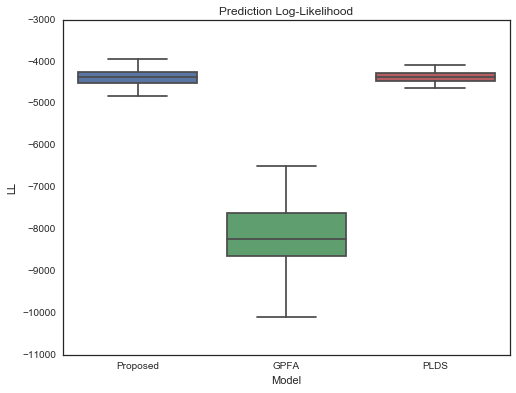

In [1286]:
LL = np.zeros((nsample, ntrial, 3))

for i in range(5):
    LL[i, :, 0] = np.nansum(stats.poisson.logpmf(LorenzCV_vLGP[i]['y'], LorenzCV_vLGP[i]['yhat']), axis=(1, 2))
    LL[i, :, 1] = np.nansum(stats.poisson.logpmf(LorenzCV_vLGP[i]['y'], LorenzCV_GPFA[i]['yhat']**2), axis=(1, 2))
    LL[i, :, 2] = np.nansum(stats.poisson.logpmf(LorenzCV_vLGP[i]['y'], LorenzCV_PLDS[i]['yhat']), axis=(1, 2))
plt.figure(figsize=(8, 6));
ax = sns.boxplot(data=pd.DataFrame(LL.reshape((-1, 3)), columns=['Proposed', 'GPFA', 'PLDS']), showfliers=False);
plt.xlabel('Model');
plt.ylabel('LL')
plt.title('Prediction Log-Likelihood');
plt.savefig(os.path.join(outputpath, 'prediction_ll_lorenz.pdf'))
# locs, labels = plt.xticks();
# plt.xticks(locs, ['PLDS', 'GPFA', 'Proposed']);